In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
from tqdm import tqdm
from keras.applications.resnet_v2 import ResNet101V2
import cv2
import math
import os
from glob import glob
from scipy import stats as s
from sklearn.externals import joblib 

Using TensorFlow backend.
C:\Users\HH TRADERS\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
base_model = ResNet101V2(weights='imagenet', include_top=False)

In [3]:
base_model.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
________________________________________________________________________________________

__________________________________________________________________________________________________
conv3_block4_1_relu (Activation (None, None, None, 1 0           conv3_block4_1_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_2_pad (ZeroPadding (None, None, None, 1 0           conv3_block4_1_relu[0][0]        
__________________________________________________________________________________________________
conv3_block4_2_conv (Conv2D)    (None, None, None, 1 147456      conv3_block4_2_pad[0][0]         
__________________________________________________________________________________________________
conv3_block4_2_bn (BatchNormali (None, None, None, 1 512         conv3_block4_2_conv[0][0]        
__________________________________________________________________________________________________
conv3_block4_2_relu (Activation (None, None, None, 1 0           conv3_block4_2_bn[0][0]          
__________

conv4_block7_1_bn (BatchNormali (None, None, None, 2 1024        conv4_block7_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block7_1_relu (Activation (None, None, None, 2 0           conv4_block7_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block7_2_pad (ZeroPadding (None, None, None, 2 0           conv4_block7_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block7_2_conv (Conv2D)    (None, None, None, 2 589824      conv4_block7_2_pad[0][0]         
__________________________________________________________________________________________________
conv4_block7_2_bn (BatchNormali (None, None, None, 2 1024        conv4_block7_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_bloc

__________________________________________________________________________________________________
conv4_block14_2_pad (ZeroPaddin (None, None, None, 2 0           conv4_block14_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_block14_2_conv (Conv2D)   (None, None, None, 2 589824      conv4_block14_2_pad[0][0]        
__________________________________________________________________________________________________
conv4_block14_2_bn (BatchNormal (None, None, None, 2 1024        conv4_block14_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block14_2_relu (Activatio (None, None, None, 2 0           conv4_block14_2_bn[0][0]         
__________________________________________________________________________________________________
conv4_block14_3_conv (Conv2D)   (None, None, None, 1 263168      conv4_block14_2_relu[0][0]       
__________

conv4_block21_2_conv (Conv2D)   (None, None, None, 2 589824      conv4_block21_2_pad[0][0]        
__________________________________________________________________________________________________
conv4_block21_2_bn (BatchNormal (None, None, None, 2 1024        conv4_block21_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block21_2_relu (Activatio (None, None, None, 2 0           conv4_block21_2_bn[0][0]         
__________________________________________________________________________________________________
conv4_block21_3_conv (Conv2D)   (None, None, None, 1 263168      conv4_block21_2_relu[0][0]       
__________________________________________________________________________________________________
conv4_block21_out (Add)         (None, None, None, 1 0           conv4_block20_out[0][0]          
                                                                 conv4_block21_3_conv[0][0]       
__________

In [4]:
#defining the model architecture
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(100352,)))
model.add(Dropout(0.5))
model.add(Dense(51, activation='softmax'))

In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              102761472 
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 51)                52275     
Total params: 102,813,747
Trainable params: 102,813,747
Non-trainable params: 0
_________________________________________________________________


In [6]:
# loading the trained weights
model.load_weights("../Models/weightResNet101V2_3.hdf5")

In [7]:
# compiling the model
model.compile(loss='categorical_crossentropy',optimizer='RMSprop',metrics=['accuracy'])

In [8]:
location='../data/test'
classes=[]
videos=[]
test=pd.DataFrame()
for foldername in sorted(os.listdir(location)):
    classes.append(foldername)
    for files in sorted(os.listdir(location+'/'+foldername)):
        videos.append(foldername+'/'+files)
test['video_name']=videos
print(classes)
test_videos=test['video_name']
test.head()

['brush_hair', 'cartwheel', 'catch', 'chew', 'clap', 'climb', 'climb_stairs', 'dive', 'draw_sword', 'dribble', 'drink', 'eat', 'fall_floor', 'fencing', 'flic_flac', 'golf', 'handstand', 'hit', 'hug', 'jump', 'kick', 'kick_ball', 'kiss', 'laugh', 'pick', 'pour', 'pullup', 'punch', 'push', 'pushup', 'ride_bike', 'ride_horse', 'run', 'shake_hands', 'shoot_ball', 'shoot_bow', 'shoot_gun', 'sit', 'situp', 'smile', 'smoke', 'somersault', 'stand', 'swing_baseball', 'sword', 'sword_exercise', 'talk', 'throw', 'turn', 'walk', 'wave']


,video_name
0,brush_hair/April_09_brush_hair_u_nm_np1_ba_goo...
1,brush_hair/April_09_brush_hair_u_nm_np1_ba_goo...
2,brush_hair/April_09_brush_hair_u_nm_np1_ba_goo...
3,brush_hair/Blonde_being_brushed_brush_hair_f_n...
4,brush_hair/Blonde_being_brushed_brush_hair_u_c...


In [9]:
# creating the tags
train = pd.read_csv('../data/train_2.csv')
y = train['class']
y = pd.get_dummies(y)

In [10]:
# creating two lists to store predicted and actual tags
predict = []
actual = []

# for loop to extract frames from each test video
for i in tqdm(range(test_videos.shape[0])):
    count = 0
    videoFile = test_videos[i]
    #print('../data/test/'+videoFile)
    cap = cv2.VideoCapture('../data/test/'+videoFile.split(' ')[0].split('/')[0]+'/'+videoFile.split(' ')[0].split('/')[1])   # capturing the video from the given path
    frameRate = cap.get(5) #frame rate
    x=1
    # removing all other files from the temp folder
    files = glob('../data/temp/*')
    for f in files:
        os.remove(f)
    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        if (frameId % math.floor(frameRate) == 0):
            # storing the frames of this particular video in temp folder
#            print('../data/temp/' + "_frame%d.jpg" % count)
            filename ='../data/temp/' + "_frame%d.jpg" % count;count+=1
            cv2.imwrite(filename, frame)
    cap.release()
    
    # reading all the frames from temp folder
    images = glob("../data/temp/*.jpg")
    
    prediction_images = []
    for i in range(len(images)):
        img = image.load_img(images[i], target_size=(224,224,3))
        img = image.img_to_array(img)
        img = img/255
        prediction_images.append(img)
        
    # converting all the frames for a test video into numpy array
    prediction_images = np.array(prediction_images)
    # extracting features using pre-trained model
    prediction_images = base_model.predict(prediction_images)
    # converting features in one dimensional array
    prediction_images = prediction_images.reshape(prediction_images.shape[0], 7*7*2048)
    # predicting tags for each array
    prediction = model.predict_classes(prediction_images)
    # appending the mode of predictions in predict list to assign the tag to the video
    predict.append(y.columns.values[s.mode(prediction)[0][0]])
    # appending the actual tag of the video
    actual.append(videoFile.split('/')[0])


100%|██████████| 1530/1530 [1:44:55<00:00,  2.72s/it]  


In [11]:
# checking the accuracy of the predicted tags
from sklearn.metrics import accuracy_score
accuracy_score(predict, actual)*100

81.17647058823529

In [12]:
from sklearn import metrics
print(metrics.classification_report(actual,predict))

                precision    recall  f1-score   support

    brush_hair       0.86      1.00      0.92        30
     cartwheel       0.91      0.97      0.94        30
         catch       0.96      0.90      0.93        30
          chew       0.80      0.93      0.86        30
          clap       0.93      0.87      0.90        30
         climb       0.85      0.97      0.91        30
  climb_stairs       0.87      0.87      0.87        30
          dive       0.90      0.93      0.92        30
    draw_sword       0.89      0.80      0.84        30
       dribble       0.94      1.00      0.97        30
         drink       0.55      0.93      0.69        30
           eat       0.90      0.63      0.75        30
    fall_floor       0.62      0.27      0.37        30
       fencing       0.87      0.90      0.89        30
     flic_flac       0.82      0.93      0.87        30
          golf       1.00      0.97      0.98        30
     handstand       0.89      0.83      0.86  

In [13]:
cm=metrics.confusion_matrix(actual,predict)
print(cm)

[[30  0  0 ...  0  0  0]
 [ 0 29  0 ...  0  0  0]
 [ 0  0 27 ...  0  0  0]
 ...
 [ 0  0  0 ... 16  7  0]
 [ 0  0  0 ...  2 24  0]
 [ 0  0  0 ...  0 10 10]]


Text(0.5, 1, 'Accuracy score: 81.17647058823529')

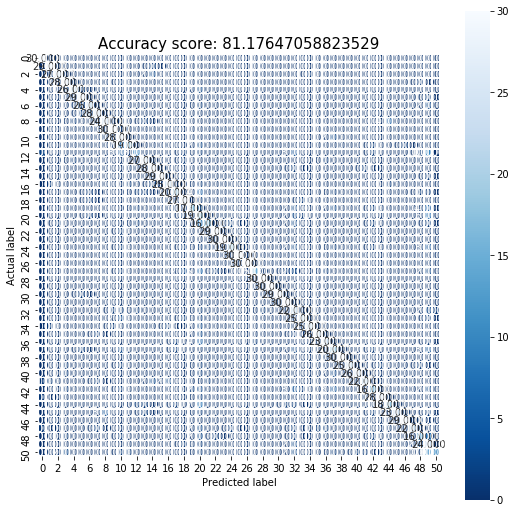

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap="Blues_r");
plt.ylabel("Actual label");
plt.xlabel("Predicted label")
all_sample_title="Accuracy score: {0}".format(metrics.accuracy_score(predict, actual)*100)
plt.title(all_sample_title,size=15)